# Global Sensitivity Analysis

This section demonstrates global sensitivity analysis using the Sobol' method. The Sobol' method is implemented using `SALib`, a Python library built specifically for performing sensitivity analysis. The method is demonstrated on the Water Flow and Welded Beam Function that are available in the benchmarking problems section of `smt`.

## 1. Water Flow Function

The water flow function can be represented as:
$$
    \begin{gathered}
        f(\textbf{x}) = \frac{2\pi T_u (H_u - H_l)}{\textrm{ln}(\frac{r}{r_w})[1 + \frac{2LT_u}{\textrm{ln}(\frac{r}{r_w})r_w^2K_w}+\frac{T_u}{T_l}]} \\
            \\
    \end{gathered}
$$

The function has 8 variables. The blocks of code below use the Water Flow Function defined in `smt` to define a function for the Sobol' method.

In [58]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from smt.sampling_methods import LHS
from smt.surrogate_models import KRG
from smt.problems import WaterFlow, WeldedBeam
from SALib.sample import sobol, latin
from SALib.analyze import sobol as SOBOL

# Defining water flow function problem
ndim = 8
waterflow = WaterFlow(ndim=ndim)

The block of code below defines the bounds of the 8 variables of the function and the sensitivity analysis problem.

In [59]:
# Defining sensitivity analysis problem
xlimits = np.array([[0.05, 0.15], [100.0, 50000.0], [63070, 115600], [990, 1110], [63.10, 116], [700, 820], [1120, 1680], [9855, 12045]])
problem = {
    'num_vars': ndim,
    'names': ['$r_w$', '$r$', '$T_u$', '$H_u$', '$T_l$', '$H_l$', '$L$', '$K_w$'],
    'bounds': xlimits
}

The next block of code uses Sobol sequences to generate samples for Monte Carlo simulations done to approximate the relevant integrals for applying the Sobol' method.  

In [60]:
param_values = sobol.sample(problem, 1024)
Y = waterflow(param_values)
Y = Y.reshape(-1)

Now, we will use the analyze method to calculate the Sobol' indices.

In [61]:
Si = SOBOL.analyze(problem, Y)

print("First-order indices:", Si['S1'])
print("\nTotal indices:", Si['ST'])

First-order indices: [ 8.25333228e-01 -1.40467348e-05 -5.41807490e-08  4.17527606e-02
 -3.82028524e-05  4.04063932e-02  3.96859536e-02  9.63442556e-03]

Total indices: [8.60305971e-01 2.15270151e-06 1.04877522e-11 5.29330610e-02
 1.06885098e-05 5.40930801e-02 5.18931057e-02 1.24399649e-02]


From the values of the Sobol' indices, it is clear that the water flow function is highly sensitive to the $r_w$ variable. Next, we will plot graphs to visualize the Sobol' indices for the different variables of the water flow function.

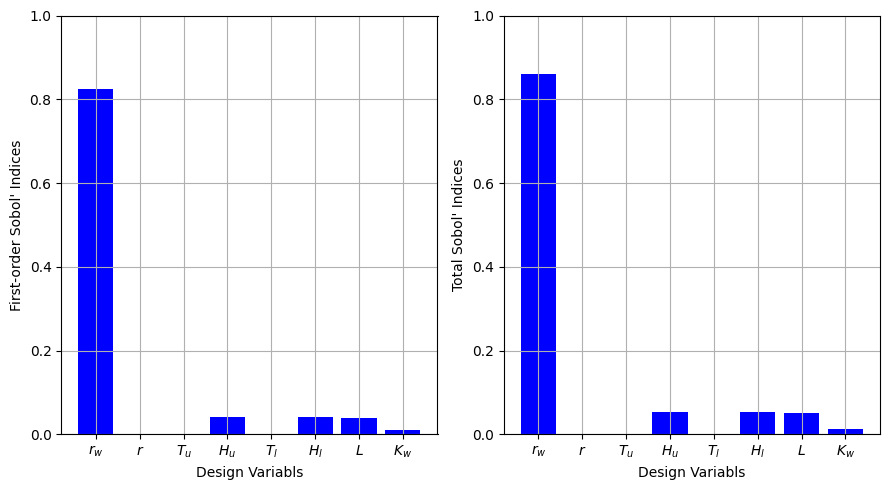

In [62]:
# Plotting first order indices
vars = problem['names']
s1_values = Si['S1']
fig, ax = plt.subplots(1,2, figsize = (9,5))
ax[0].bar(vars, s1_values, color ='blue', width = 0.8)
ax[0].set_xlabel("Design Variabls")
ax[0].set_ylabel("First-order Sobol' Indices")
ax[0].grid()
ax[0].set_ylim([0.0, 1.0])

# Plotting total indices
st_values = Si['ST']
ax[1].bar(vars, st_values, color ='blue', width = 0.8)
ax[1].set_xlabel("Design Variabls")
ax[1].set_ylabel("Total Sobol' Indices")
ax[1].grid()
ax[1].set_ylim([0.0, 1.0])
plt.tight_layout()

Using surrogates instead of the true function. Creating a kriging model of the water flow function and varying the number of samples and plotting sobol indices for each number of samples. 


Number of samples: 5
First-order indices: [ 1.81550459e-03  4.39211294e-05  8.30422306e-07 -3.17867366e-06
  9.65594184e-01 -3.46628656e-07  3.44819042e-03  1.62302675e-02]

Total indices: [1.97536226e-03 1.63983854e-05 1.27487526e-08 1.64042224e-07
 9.76725223e-01 3.53794190e-07 1.26318196e-02 2.13675708e-02]

Number of samples: 10
First-order indices: [ 9.53259164e-01  4.36818582e-02 -1.13201166e-05  1.26863437e-06
  1.73815968e-05  2.57752024e-04 -5.73314232e-08  9.26558461e-05]

Total indices: [9.67628938e-01 4.98751453e-02 7.91524017e-06 9.19254149e-08
 8.14613264e-06 2.65464157e-04 7.92778534e-10 5.93873302e-05]

Number of samples: 15
First-order indices: [8.13214104e-01 9.44583203e-06 1.11837479e-06 2.98684083e-02
 2.60913540e-03 6.48777491e-02 4.47945525e-02 4.60912404e-03]

Total indices: [8.47275331e-01 1.73887535e-07 1.47819833e-05 3.67454953e-02
 3.68988448e-03 8.37655072e-02 5.09331514e-02 4.74861945e-03]

Number of samples: 20
First-order indices: [8.27130572e-01 9.66410

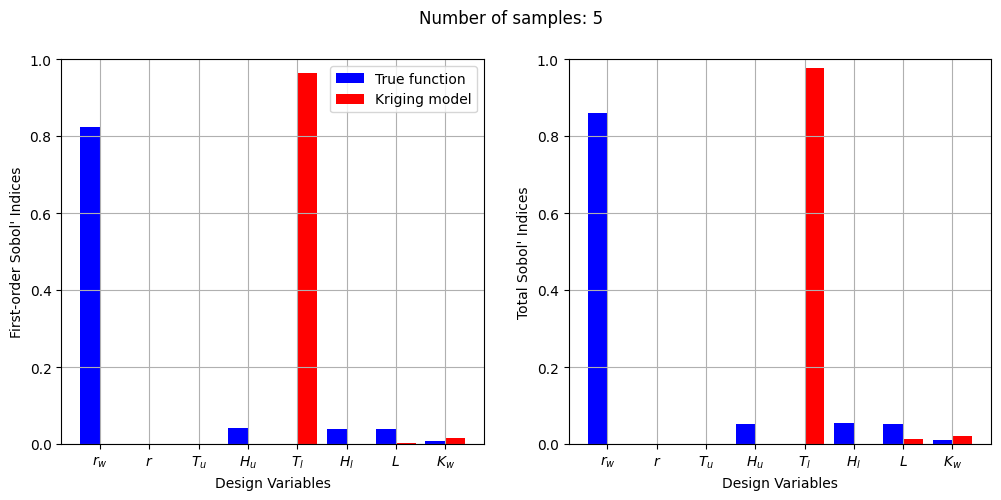

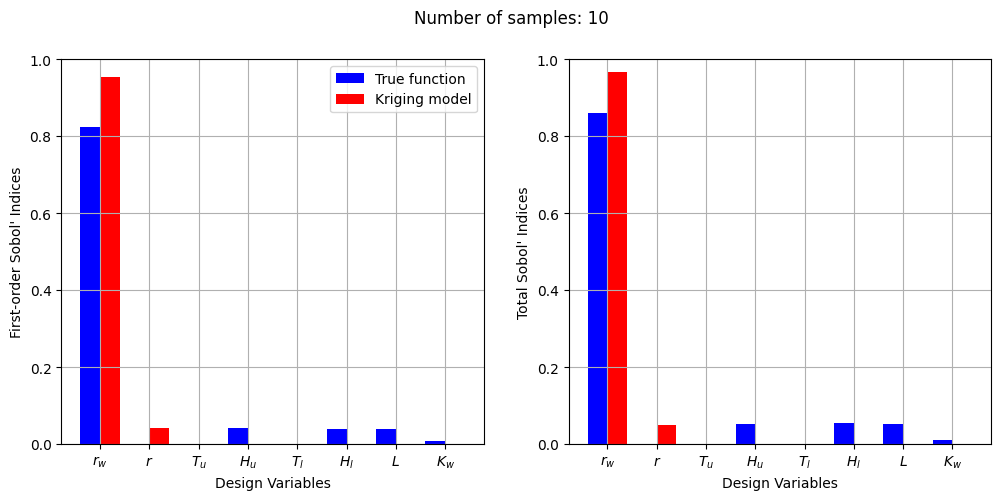

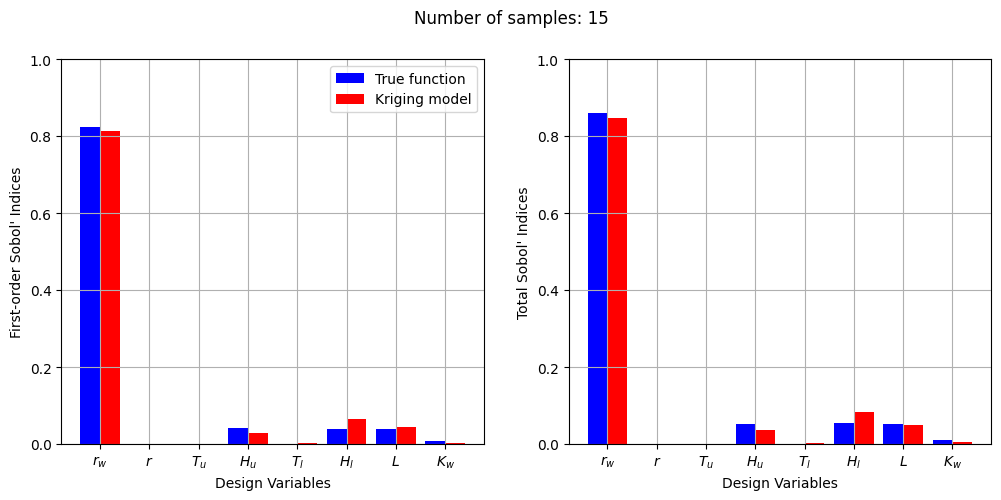

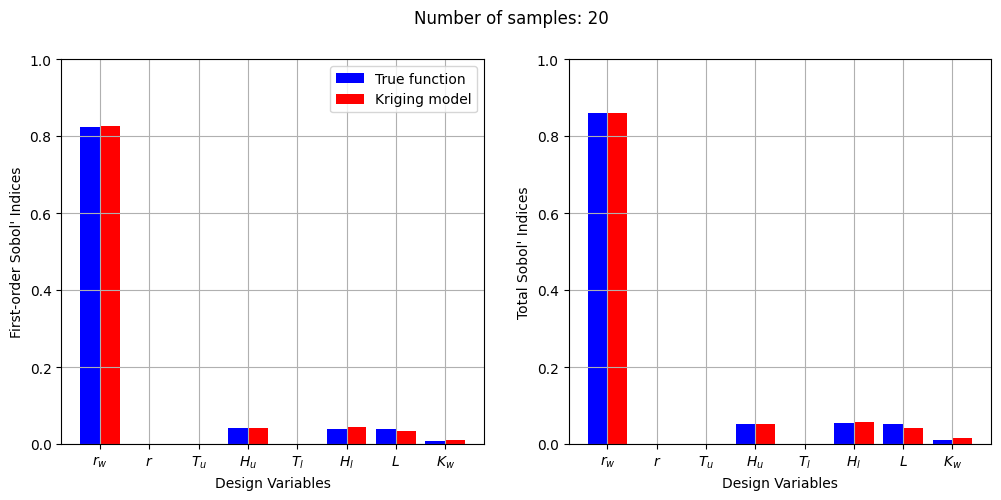

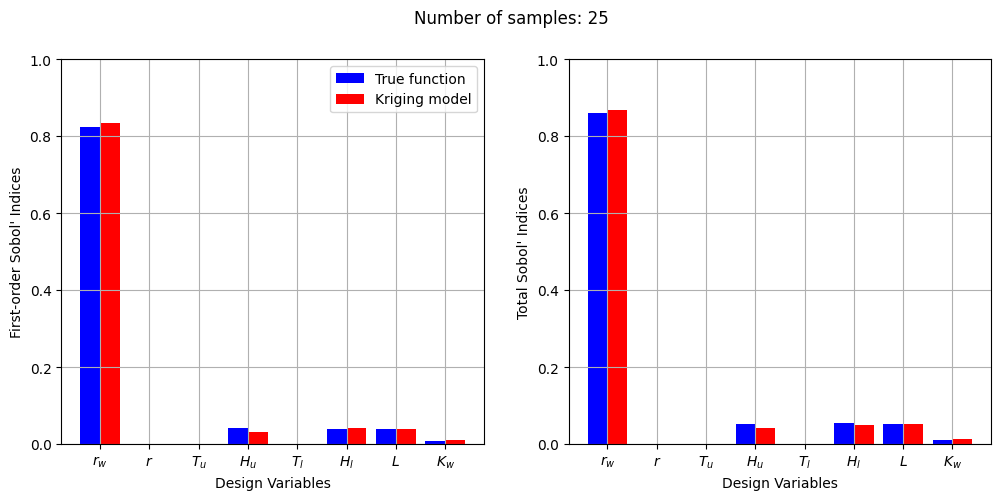

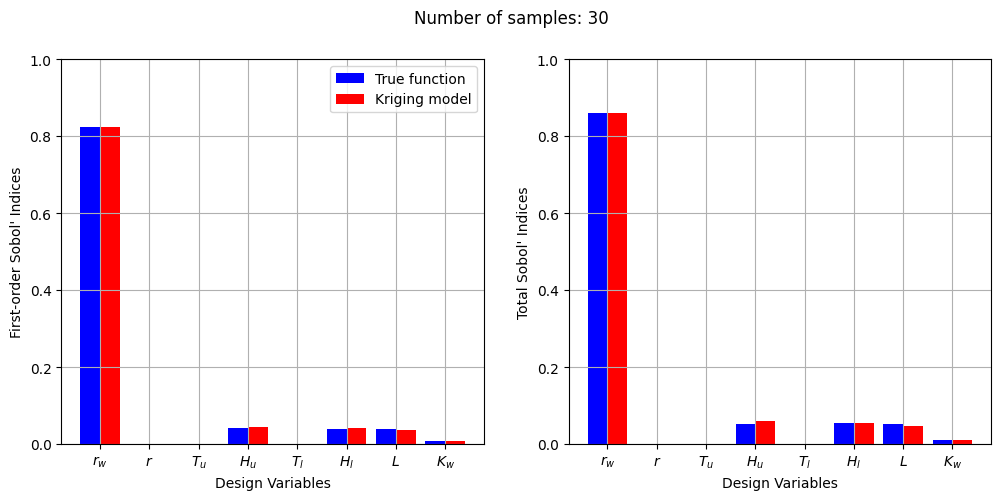

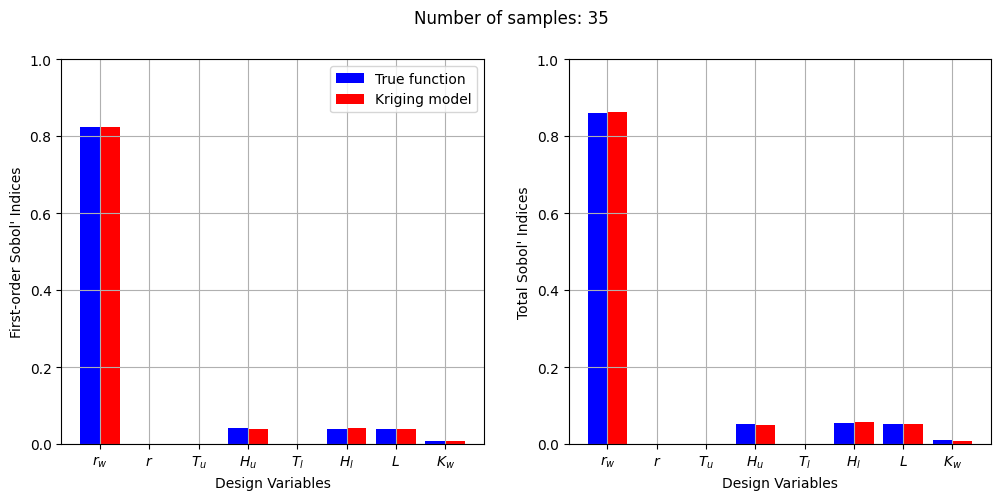

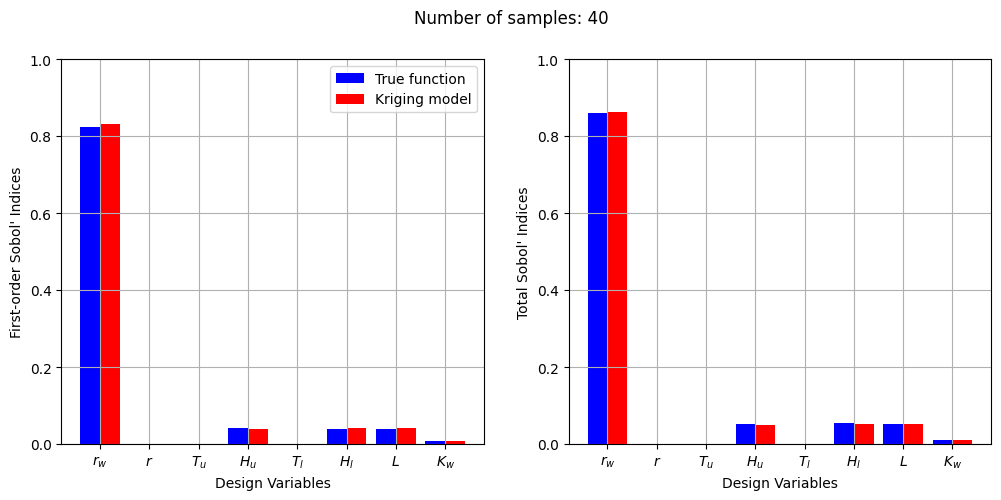

In [63]:
samples = [5,10,15,20,25,30,35,40]

for size in samples:

    # Generate training samples using LHS
    sampling = LHS(xlimits=xlimits, criterion="ese")
    xtrain = sampling(size)
    ytrain = waterflow(xtrain)

    # Create kriging model
    corr = 'squar_exp'
    sm = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)
    sm.set_training_values(xtrain, ytrain)
    sm.train()

    # Generate values for Sobol sequence samples using the surrogate
    surrogate_Y = sm.predict_values(param_values)
    surrogate_Y = surrogate_Y.reshape(-1)
    
    Si_surrogate = SOBOL.analyze(problem, surrogate_Y)
    print("\nNumber of samples:", size)
    print("First-order indices:", Si_surrogate['S1'])
    print("\nTotal indices:", Si_surrogate['ST'])
    
    # Plotting first order indices 
    vars = problem['names']
    s1_surrogate = Si_surrogate['S1']
    r = np.arange(len(s1_surrogate))
    width = 0.4
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].bar(r, s1_values, color ='blue', width = width, label = "True function")
    ax[0].bar(r+width, s1_surrogate, color ='red', width = width, label = "Kriging model")
    ax[0].set_xlabel("Design Variables")
    ax[0].set_ylabel("First-order Sobol' Indices")
    ax[0].set_xticks(r + width/2,vars) 
    ax[0].legend()
    ax[0].grid()
    ax[0].set_ylim([0.0, 1.0])

    # Plotting total indices
    st_surrogate = Si_surrogate['ST']
    ax[1].bar(r, st_values, color ='blue', width = width, label = "True function")
    ax[1].bar(r+width, st_surrogate, color ='red', width = width, label = "Kriging model")
    ax[1].set_xlabel("Design Variables")
    ax[1].set_ylabel("Total Sobol' Indices")
    ax[1].set_xticks(r + width/2,vars) 
    ax[1].grid()
    ax[1].set_ylim([0.0, 1.0])
    fig.suptitle("Number of samples: {}".format(size))

## 2. Welded Beam Function

The welded beam function can be represented as:
$$
    \begin{gathered}
        f(\textbf{x}) =  \\
            \\
    \end{gathered}
$$

The function has 3 variables. The blocks of code below use the Welded Beam Function defined in `smt` to define a function for the Sobol' method.

In [64]:
ndim = 3
weldedbeam = WeldedBeam(ndim=ndim)

Now, we will apply the same procedure as the water flow function to calculate the Sobol' indices for the welded beam function.

In [65]:
# Defining sensitivity analysis problem
xlimits = np.array([[0.125, 1.0], [5.0, 10.0], [5.0, 10.0]])
problem = {
    'num_vars': ndim,
    'names': ['$h$', '$l$', '$t$'],
    'bounds': xlimits
}
param_values = sobol.sample(problem, 1024)
Y = weldedbeam(param_values)
Y = Y.reshape(-1)

In [66]:
Si = SOBOL.analyze(problem, Y)

print("First-order indices:", Si['S1'])
print("\nTotal indices:", Si['ST'])

First-order indices: [0.00997659 0.95683814 0.02691913]

Total indices: [0.0149239  0.96384449 0.02887234]


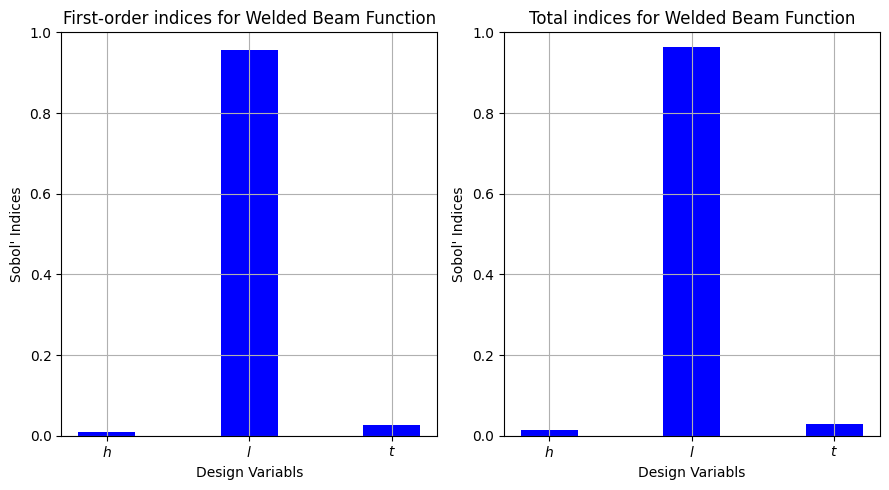

In [67]:
# Plotting first order indices
vars = problem['names']
s1_values = Si['S1']
fig, ax = plt.subplots(1, 2, figsize=(9,5))
ax[0].bar(vars, s1_values, color ='blue', width = 0.4)
ax[0].set_xlabel("Design Variabls")
ax[0].set_ylabel("Sobol' Indices")
ax[0].set_title("First-order indices for Welded Beam Function")
ax[0].grid()
ax[0].set_ylim([0.0, 1.0])

# Plotting total indices
st_values = Si['ST']
ax[1].bar(vars, st_values, color ='blue', width = 0.4)
ax[1].set_xlabel("Design Variabls")
ax[1].set_ylabel("Sobol' Indices")
ax[1].set_title("Total indices for Welded Beam Function")
ax[1].grid()
ax[1].set_ylim([0.0, 1.0])
plt.tight_layout()


Number of samples: 5
First-order indices: [-5.65514831e-08  9.79996156e-01  1.92183567e-02]

Total indices: [2.78677642e-09 9.80722096e-01 1.98289182e-02]

Number of samples: 10
First-order indices: [0.0045175  0.96982767 0.02354606]

Total indices: [0.00484272 0.97201986 0.02553376]

Number of samples: 15
First-order indices: [0.00816947 0.96390814 0.02409232]

Total indices: [0.01126248 0.96796856 0.0250729 ]

Number of samples: 20
First-order indices: [0.00963104 0.95919081 0.02481805]

Total indices: [0.01514408 0.96577308 0.02650192]

Number of samples: 25
First-order indices: [0.01059899 0.95712009 0.02626423]

Total indices: [0.01482453 0.96397143 0.02834464]

Number of samples: 30
First-order indices: [0.00972515 0.95724169 0.02692765]

Total indices: [0.01426719 0.96354829 0.02902243]


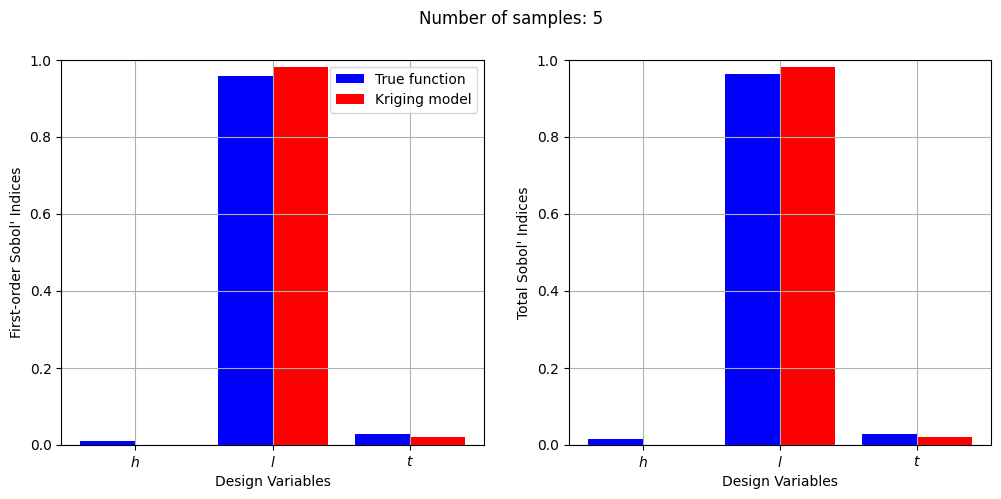

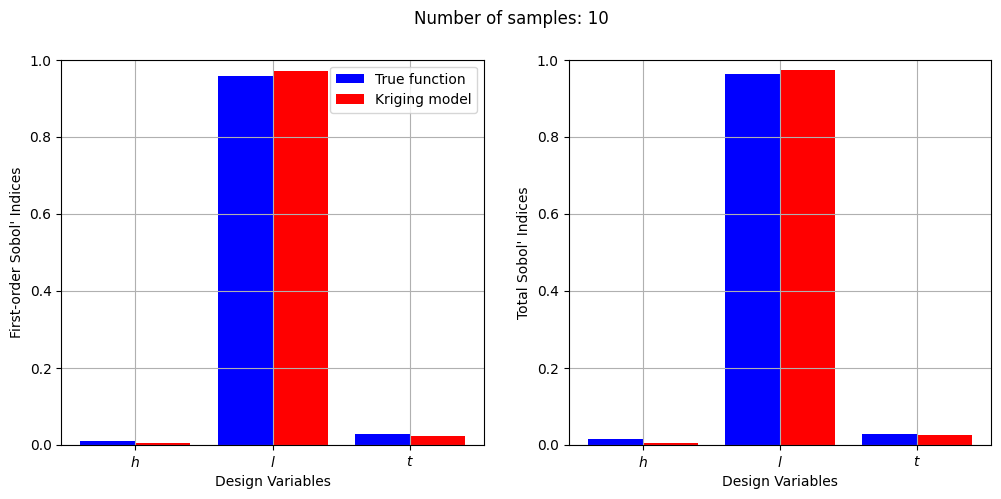

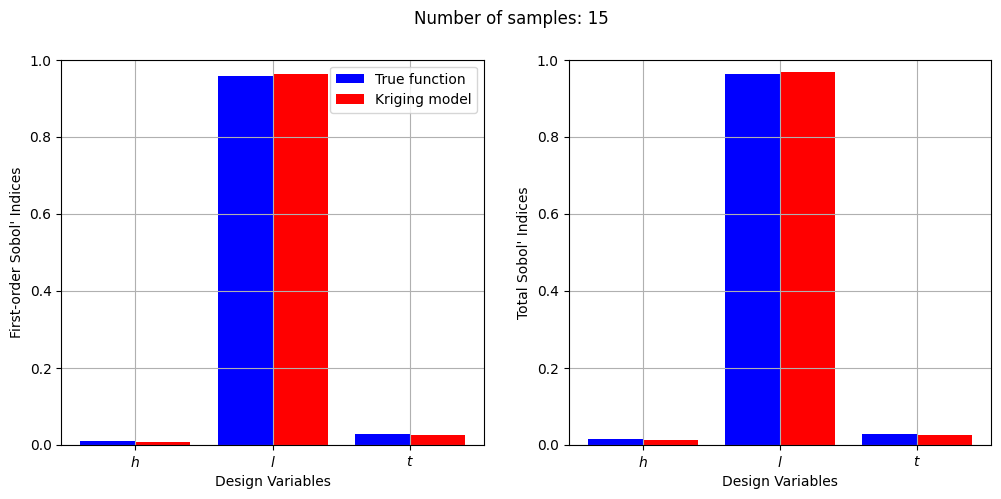

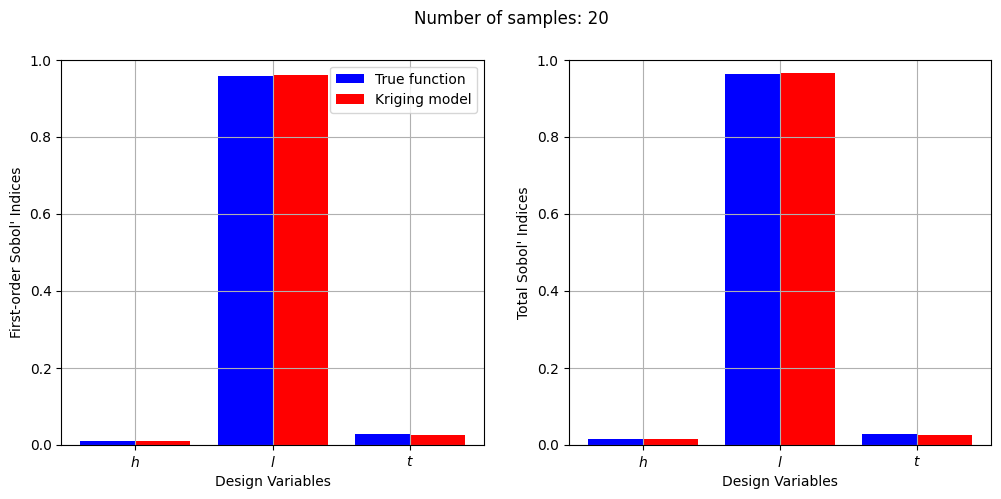

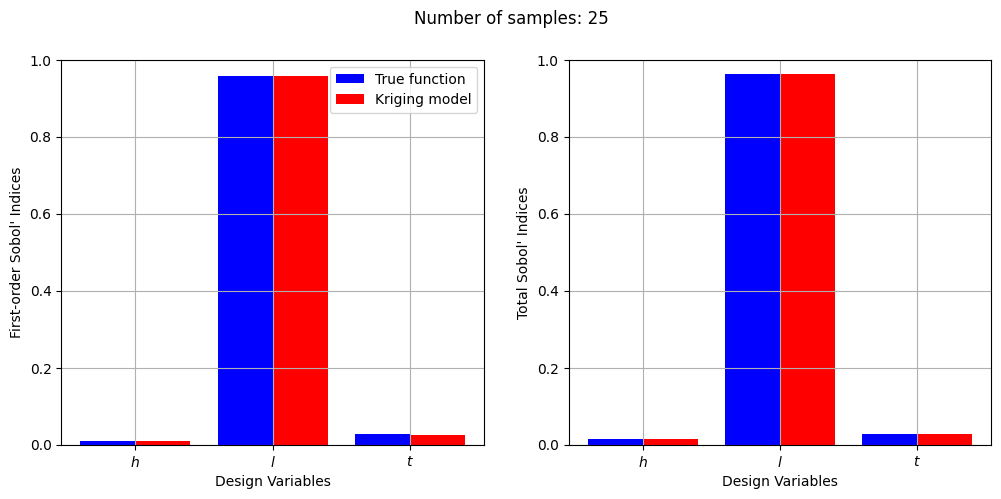

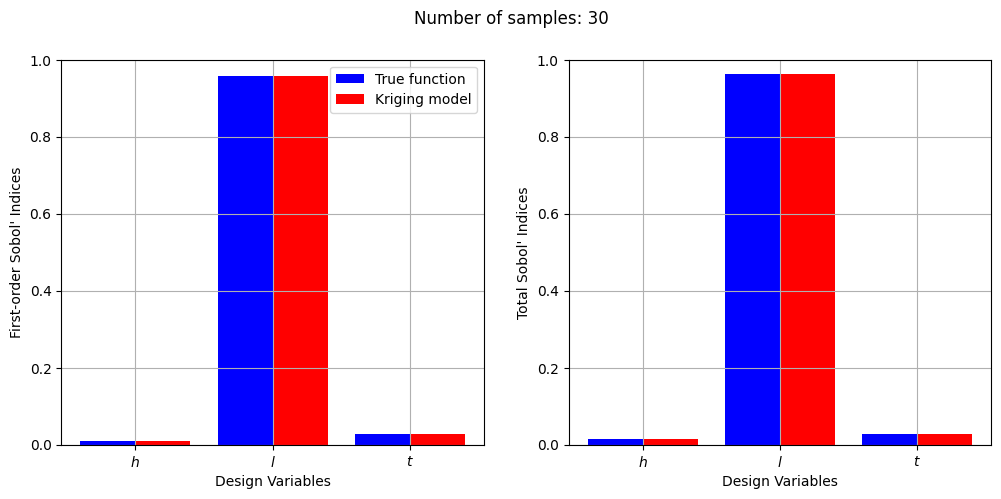

In [68]:
samples = [5,10,15,20,25,30]

for size in samples:

    # Generate training samples using LHS
    sampling = LHS(xlimits=xlimits, criterion="ese")
    xtrain = sampling(size)
    ytrain = weldedbeam(xtrain)

    # Create kriging model
    corr = 'squar_exp'
    sm = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)
    sm.set_training_values(xtrain, ytrain)
    sm.train()

    # Generate values for Sobol sequence samples using the surrogate
    surrogate_Y = sm.predict_values(param_values)
    surrogate_Y = surrogate_Y.reshape(-1)
    
    Si_surrogate = SOBOL.analyze(problem, surrogate_Y)
    print("\nNumber of samples:", size)
    print("First-order indices:", Si_surrogate['S1'])
    print("\nTotal indices:", Si_surrogate['ST'])
    
    # Plotting first order indices 
    vars = problem['names']
    s1_surrogate = Si_surrogate['S1']
    r = np.arange(len(s1_surrogate))
    width = 0.4
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].bar(r, s1_values, color ='blue', width = width, label = "True function")
    ax[0].bar(r+width, s1_surrogate, color ='red', width = width, label = "Kriging model")
    ax[0].set_xlabel("Design Variables")
    ax[0].set_ylabel("First-order Sobol' Indices")
    ax[0].set_xticks(r + width/2,vars) 
    ax[0].legend()
    ax[0].grid()
    ax[0].set_ylim([0.0, 1.0])

    # Plotting total indices
    st_surrogate = Si_surrogate['ST']
    ax[1].bar(r, st_values, color ='blue', width = width, label = "True function")
    ax[1].bar(r+width, st_surrogate, color ='red', width = width, label = "Kriging model")
    ax[1].set_xlabel("Design Variables")
    ax[1].set_ylabel("Total Sobol' Indices")
    ax[1].set_xticks(r + width/2,vars) 
    ax[1].grid()
    ax[1].set_ylim([0.0, 1.0])
    fig.suptitle("Number of samples: {}".format(size))